# CutQC Tutorial 1: Circuit Cutting with Automatic Cut Finding

Circuit cutting is a technique to decompose a quantum circuit into smaller circuits, whose results can be knitted together to reconstruct the original circuit output. 

The circuit knitting toolbox implements a wire cutting method presented in [CutQC](https://doi.org/10.1145/3445814.3446758) (Tang et al.). This method allows a circuit wire to be cut such that the generated subcircuits are amended by measurements in the Pauli bases and by state preparation of four Pauli eigenstates (see Fig. 4 of [CutQC](https://doi.org/10.1145/3445814.3446758)).

This wire cutting technique is comprised of the following basic steps:

1. **Decompose**: Cut a circuit into multiple subcircuits. Here, we'll use an automatic method to find optimal cut(s). See [tutorial 2](tutorial_2_manual_cutting.ipynb) to manually cut a circuit.
2. **Evaluate**: Execute those subcircuits on quantum backend(s).
3. **Reconstruct**: Knit the subcircuit results together to reconstruct the original circuit output (in this case, the full probability distribution).

## Create a quantum circuit with Qiskit

In this case, we'll create a hardware-efficient circuit (`EfficientSU2` from the Qiskit circuit library) with two (linear) entangling layers.

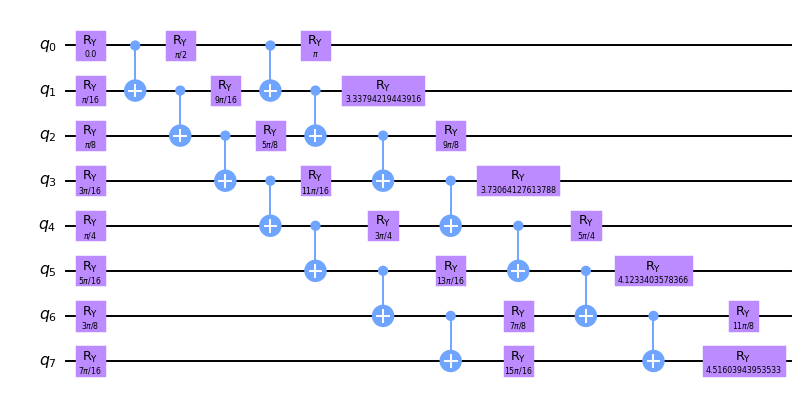

In [5]:
import numpy as np
from qiskit.circuit.library import EfficientSU2

num_qubits = 8
circuit = EfficientSU2(
    num_qubits=num_qubits,
    reps=2,
    entanglement="linear",
    su2_gates=["ry"],
)

circuit = circuit.decompose()

params = [(np.pi * i) / 16 for i in range(len(circuit.parameters))]
circuit.assign_parameters(params, inplace=True)
circuit.draw("mpl", fold=-1, scale=0.7)

## Decompose the circuit with wire cutting

In this example, we will use an automatic method to find cuts matching our criteria. See [tutorial 2](tutorial_2_manual_cutting.ipynb) for how to manually cut a circuit.

   * `method='automatic'`: Use a mixed integer programming (MIP) model to find optimal cut(s)
   * `max_subcircuit_width=6`: Only allow subcircuits with 6 qubits or less
   * `max_cuts=2`: Cut the circuit no more than two times
   * `num_subcircuits=[2]`: A list of the number of subcircuits to try, in this case 2 subcircuits

In [6]:
%%capture

from circuit_knitting.cutting.cutqc import cut_circuit_wires

cuts = cut_circuit_wires(
    circuit=circuit,
    method="automatic",
    max_subcircuit_width=5,
    max_cuts=2,
    num_subcircuits=[2],
)

**The results from decompose includes information about the wire cutting process, e.g.,**

- `subcircuits`: list of `QuantumCircuit` objects for the subcircuits
- `complete_path_map`: a dictionary mapping indices of qubits in original circuit to their indices in the subcircuits. Note that some qubit indices may be mapped to more than one subcircuit.
- `num_cuts`: the number of times the circuit was cut
- `classical_cost`: the final value of the objective function used to find optimal cut(s). The objective function represents the postprocessing cost to reconstruct the original circuit output and is set to be the number of floating-point multiplications involved in the reconstruction. This quantity is also returned in the case of [manual wire cutting](tutorial_2_manual_cutting.ipynb). See [Section 4.1.4 of CutQC](https://doi.org/10.1145/3445814.3446758).

In [7]:
print(cuts.keys())

dict_keys(['max_subcircuit_width', 'subcircuits', 'complete_path_map', 'num_cuts', 'counter', 'classical_cost'])


**The two subcircuits produced:**

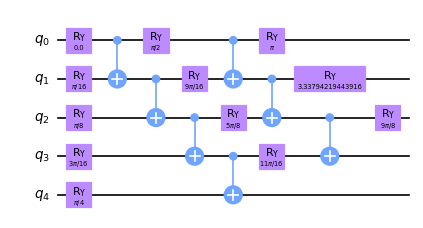

In [8]:
# visualize the first subcircuit
cuts["subcircuits"][0].draw("mpl", fold=-1, scale=0.6)

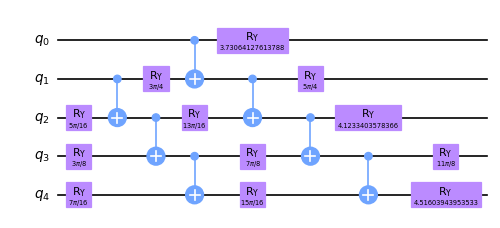

In [9]:
# visualize the second subcircuit
cuts["subcircuits"][1].draw("mpl", fold=-1, scale=0.6)

## Evaluate the subcircuits

**Set up the Qiskit Runtime Service**

The Qiskit Runtime Service provides access to Qiskit Runtime Primitives and quantum backends. See the [Qiskit Runtime documentation](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/) for more information.
Alternatively, if a Qiskit Runtime Service is not passed, then a local statevector simulator will be used with the [Qiskit Primitives](https://qiskit.org/documentation/apidoc/primitives.html).

In [10]:
from qiskit_ibm_runtime import QiskitRuntimeService  # noqa: F401

# Use local versions of the primitives by default.
service = None

# Uncomment the following line to instead use Qiskit Runtime Service.
# service = QiskitRuntimeService()

**Configure the Qiskit Runtime Primitive**

The wire cutter tool uses a `Sampler` primitive to evaluate the probabilities of each subcircuit. Here, we configure the options for the Qiskit Runtime Sampler and specify the backend(s) to be used to evaluate the subcircuits. Backends could be [simulator(s) and/or quantum device(s)](https://quantum-computing.ibm.com/services/resources?tab=systems). In this tutorial, two local cores will be used to support each of the parallel backend threads we'll specify below.

If no service was set up, the `backend_names` argument will be ignored, and Qiskit Primitives will be used with statevector simulator.

In [11]:
from qiskit_ibm_runtime import Options

# Set the Sampler and runtime options
options = Options(execution={"shots": 4000})

# Run 2 parallel qasm simulator threads
backend_names = ["ibmq_qasm_simulator"] * 2

**Evaluate the subcircuits on the backend(s)**

In [12]:
from circuit_knitting.cutting.cutqc import evaluate_subcircuits

subcircuit_instance_probabilities = evaluate_subcircuits(cuts)

# Uncomment the following lines to instead use Qiskit Runtime Service as configured above.
# subcircuit_instance_probabilities = evaluate_subcircuits(cuts,
#                                                          service_args=service.active_account(),
#                                                          backend_names=backend_names,
#                                                          options=options,
#                                                         )

**Inspecting the subcircuit results**

In this case, the original circuit was cut 2 times (we can also get this info from the previous step: `cuts['num_cuts']`):

In [13]:
print("Number of subcircuits: ", len(subcircuit_instance_probabilities))

Number of subcircuits:  2


From these two wire cuts, there are $4^2=16$ variants of the first subcircuit corresponding to the combination of measurement bases: $P_i\otimes P_j$, for the Paulis $P_i \in \{I, X, Y, Z \}$. And there are $4^2=16$ variants of the second subcircuit corresponding to the combination of initialization states: $|s_i\rangle\otimes|s_j\rangle$, where $|s_i\rangle \in \{ |0\rangle, |1\rangle, |+\rangle |+i\rangle\}$. 


Note that some subcircuit probabilities returned by the evaluate step can be negative (and not sum to unity). This is because the raw probabilities from subcircuits must be modified to account for the measurement bases of ancillary qubits. See Section 3 of [CutQC](https://doi.org/10.1145/3445814.3446758) for more details.

In [14]:
print(
    "Number of variants of 1st subcircuit: ", len(subcircuit_instance_probabilities[0])
)
print(
    "Number of variants of 2nd subcircuit: ", len(subcircuit_instance_probabilities[1])
)

Number of variants of 1st subcircuit:  16
Number of variants of 2nd subcircuit:  16


The first subcircuit has two ancillary qubits (induced by the two wire cuts) that do not appear in the original circuit. This means that the first subcircuit has $5-2=3$ qubits from the original circuit and a probability distribution of size $2^3=8$. The second subcircuit has 5 qubits, all from the original circuit, and so its probability distribution is size $2^5=32$.

In [15]:
print(
    "Size of 1st subcircuit probability distribution: ",
    len(subcircuit_instance_probabilities[0][0]),
)
print(
    "Size of 2nd subcircuit probability distribution: ",
    len(subcircuit_instance_probabilities[1][0]),
)

Size of 1st subcircuit probability distribution:  8
Size of 2nd subcircuit probability distribution:  32


## Reconstruct the full circuit output

Next, the results of the subcircuit experiments are classically postprocessed to reconstruct the original circuit's full probability distribution.

In [16]:
%%capture

from circuit_knitting.cutting.cutqc import (
    reconstruct_full_distribution,
)

reconstructed_probabilities = reconstruct_full_distribution(
    circuit, subcircuit_instance_probabilities, cuts
)

**Here are the reconstructed probabilities for the original 8-qubit circuit:**

In [17]:
print(
    "Size of reconstructed probability distribution: ", len(reconstructed_probabilities)
)

Size of reconstructed probability distribution:  256


## Verify the results

If the original circuit is small enough, we can use a statevector simulator to check the results of cutting against the original circuit's exact probability distribution (ground truth).

In [18]:
from circuit_knitting.cutting.cutqc import verify

metrics, exact_probabilities = verify(circuit, reconstructed_probabilities)

**The verify step includes several metrics**

For example, the chi square loss is computed. Since we're using the Qiskit Sampler with statevector simulator, we expect the reconstructed distributed to exactly match the ground truth. More info about each metric can be found in the [utils metrics file](https://github.com/Qiskit-Extensions/circuit-knitting-toolbox/blob/main/circuit_knitting/utils/metrics.py).

In [19]:
metrics

{'nearest': {'chi2': 0,
  'Mean Squared Error': 8.13178352181795e-35,
  'Mean Absolute Percentage Error': 4.4880309854901524e-10,
  'Cross Entropy': 3.564551116068219,
  'HOP': 0.9945381353717198},
 'naive': {'chi2': 0,
  'Mean Squared Error': 3.7794080473092745e-35,
  'Mean Absolute Percentage Error': 4.4880563544629694e-10,
  'Cross Entropy': 3.564551116068219,
  'HOP': 0.99453813537172}}

**Visualize both distributions**

If we calculated the ground truth above, we can visualize a comparison to the reconstructed probabilities

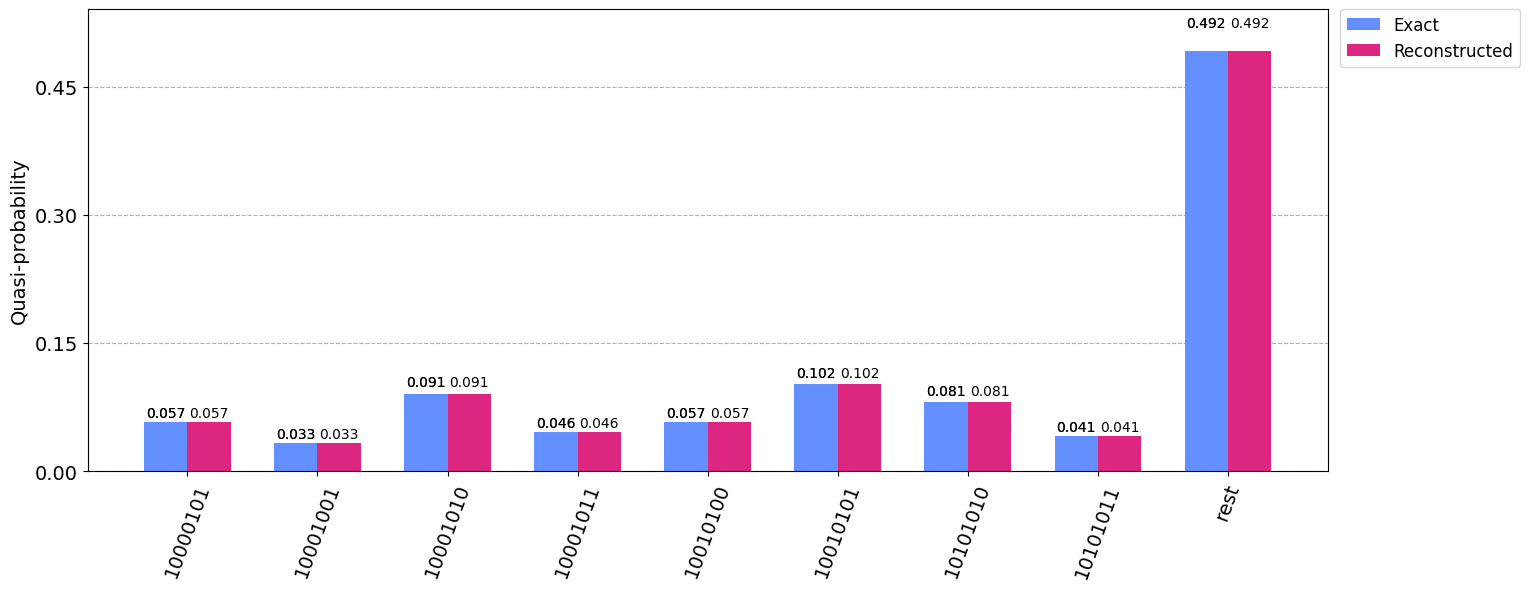

In [20]:
from qiskit.visualization import plot_histogram
from qiskit.result import ProbDistribution

# Create a dict for the reconstructed distribution
reconstructed_distribution = {
    i: prob for i, prob in enumerate(reconstructed_probabilities)
}

# Represent states as bitstrings (instead of ints)
reconstructed_dict_bitstring = ProbDistribution(
    data=reconstructed_distribution
).binary_probabilities(num_bits=num_qubits)


# Create the ground truth distribution dict
exact_distribution = {i: prob for i, prob in enumerate(exact_probabilities)}

# Represent states as bitstrings (instead of ints)
exact_dict_bitstring = ProbDistribution(data=exact_distribution).binary_probabilities(
    num_bits=num_qubits
)

# plot a histogram of the distributions
plot_histogram(
    [exact_dict_bitstring, reconstructed_dict_bitstring],
    number_to_keep=8,
    figsize=(16, 6),
    sort="asc",
    legend=["Exact", "Reconstructed"],
)

In [21]:
import qiskit.tools.jupyter  # noqa: F401

%qiskit_version_table

This code is a Qiskit project.
© Copyright IBM 2022.

This code is licensed under the Apache License, Version 2.0. You may
obtain a copy of this license in the LICENSE.txt file in the root directory
of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.

Any modifications or derivative works of this code must retain this
copyright notice, and modified files need to carry a notice indicating
that they have been altered from the originals.